# Feature Exploration of our Datasets

In [1]:
%load_ext lab_black

In [84]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings
import sys
from numpy import interp
from pprint import pprint
import sys
import joblib
import pandas as pd

warnings.filterwarnings("ignore")

import mne

mne.set_log_level("ERROR")
from mne_bids import (
    BIDSPath,
    get_entities_from_fname,
    get_entity_vals,
    read_raw_bids,
    get_bids_path_from_fname,
)

from eztrack.io import read_derivative_npy

sys.path.append("../../")
from episcalp.features import spike_feature_vector, heatmap_features
from episcalp.io.read import (
    load_persyst_spikes,
    load_reject_log,
    load_derivative_heatmaps,
    map_rejectlog_to_deriv,
    load_all_spatiotemporal_datasets,
    read_scalp_eeg,
)
from episcalp.montage import _standard_lobes, get_standard_1020_channels
from episcalp.utils.utils import NumpyEncoder
from episcalp.cross_validate import (
    exclude_subjects,
    run_exhaustive_heatmap_evaluation,
    convert_experimental_cond_to_y,
)

from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    recall_score,
    jaccard_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    precision_score,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    cohen_kappa_score,
    make_scorer,
    precision_recall_fscore_support,
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_validate,
    StratifiedShuffleSplit,
    LeaveOneGroupOut,
)
from sklearn.utils import resample
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

# if you installed sporf via README
from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Data Directories

In [3]:
user = "adam"
if user == "patrick":
    jhroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
    jeffroot = Path("D:/OneDriveParent/Johns Hopkins/Jefferson_Scalp - Documents/root")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")
elif user == "adam":
    jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
    jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [4]:
bids_roots = [jhroot, jeffroot]

In [5]:
roots = [jhroot, jeffroot]

In [6]:
if user == "adam":
    deriv_dir = Path(
        "/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives"
    )
elif user == "patrick":
    deriv_dir = Path(
        "D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/derivatives"
    )

# Load Metadata DF

In [47]:
meta_df = pd.DataFrame()

for name, root in zip(["jhh", "jeff"], roots):
    part_fname = Path(root) / "participants.tsv"
    this_df = pd.read_csv(part_fname, delimiter="\t")
    this_df["center"] = name
    meta_df = pd.concat((meta_df, this_df))

In [48]:
display(meta_df.head())
print(meta_df.shape)

,participant_id,age,sex,hand,site,exp_condition,outcome,num_aeds,final_diagnosis,epilepsy_type,epilepsy_hemisphere,epilepsy_lobe,center,orig_sub_id
0,sub-jhh001,17.0,female,right,BV,non-epilepsy-normal-eeg,0.0,0.0,pnes,NaN,NaN,NaN,jhh,NaN
1,sub-jhh002,58.0,female,right,BV,non-epilepsy-normal-eeg,0.0,0.0,pnes,NaN,NaN,NaN,jhh,NaN
2,sub-jhh003,52.0,female,right,BV,non-epilepsy-normal-eeg,0.0,0.0,pnes,NaN,NaN,NaN,jhh,NaN
3,sub-jhh004,36.0,female,right,BV,non-epilepsy-normal-eeg,0.0,1.0,pnes,NaN,NaN,NaN,jhh,NaN
4,sub-jhh005,30.0,female,right,BV,non-epilepsy-normal-eeg,0.0,1.0,pnes,NaN,NaN,NaN,jhh,NaN


(156, 14)


In [9]:
# exclusion of certain classes
meta_df = meta_df[meta_df["epilepsy_type"] != "generalized"]
print(meta_df.shape)

(149, 14)


<AxesSubplot:xlabel='sex', ylabel='count'>

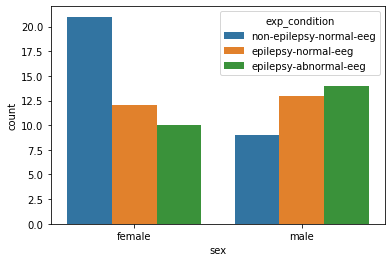

In [10]:
sns.countplot(x="sex", data=meta_df, hue="exp_condition")

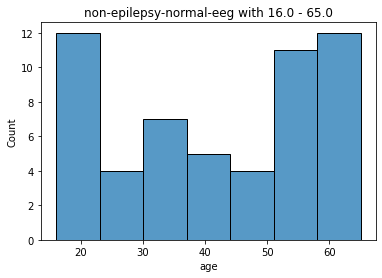

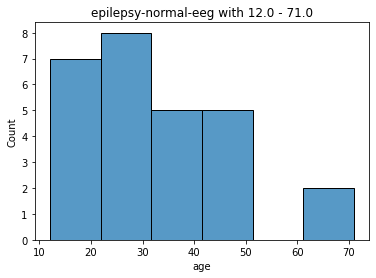

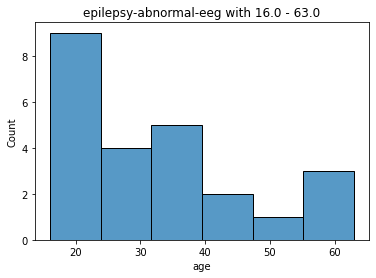

In [11]:
for exp in meta_df["exp_condition"].unique():
    fig, ax = plt.subplots()
    df = meta_df[meta_df["exp_condition"] == exp]
    sns.histplot(x="age", data=df, ax=ax)
    min_age = df["age"].min()
    max_age = df["age"].max()
    ax.set_title(f"{exp} with {min_age} - {max_age}")

(38, 14)


<AxesSubplot:xlabel='epilepsy_lobe', ylabel='count'>

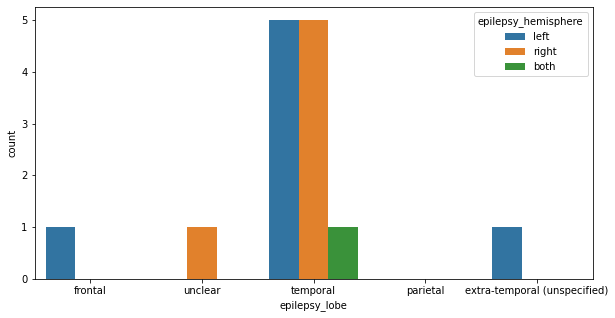

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
df = meta_df[meta_df["exp_condition"] == "epilepsy-normal-eeg"]
print(df.shape)
sns.countplot(x="epilepsy_lobe", hue="epilepsy_hemisphere", data=df, ax=ax)
# min_age = df["age"].min()
# max_age = df["age"].max()
# ax.set_title(f"{exp} with {min_age} - {max_age}")

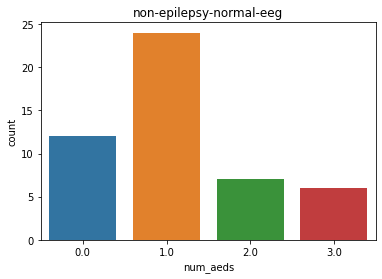

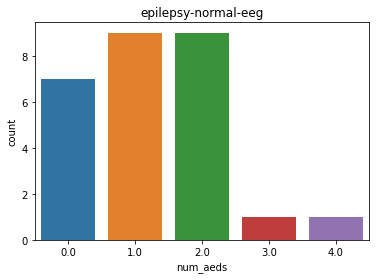

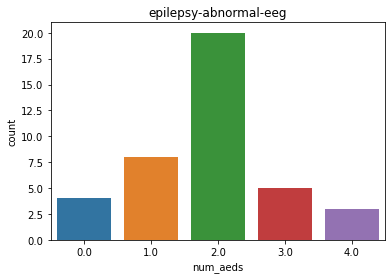

In [13]:
for exp in meta_df["exp_condition"].unique():
    fig, ax = plt.subplots()
    df = meta_df[meta_df["exp_condition"] == exp]
    sns.countplot(x="num_aeds", data=df, ax=ax)
    #     min_age = df["age"].min()
    #     max_age = df["age"].max()
    ax.set_title(f"{exp}")

# Analysis of Raw Time Features

In [14]:
import mne_features
from mne_features import get_univariate_funcs
from mne_features.univariate import compute_ptp_amp, compute_skewness

In [15]:
reference = "monopolar"
features = ["ptp_amp", "skewness", "mean", "variance", "kurtosis", "line_length"]

In [21]:
ica_deriv_chain = Path("ICA") / "1-30Hz-30" / "win-20"

In [26]:
ch_names = raw.ch_names
print(ch_names)

['Fp1', 'Fp2', 'F3', 'F4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6']


In [27]:
print(raw.ch_names)

['Fp1', 'Fp2', 'F3', 'F4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6']


In [ ]:
from numpy.testing import assert_array_equal

# check if there are extra channels
for root in roots:
    subjects = get_entity_vals(root, "subject")
    for subject in subjects:
        subj_dir = root / "derivatives" / ica_deriv_chain / f"sub-{subject}"

        fpaths = subj_dir.rglob("*.edf")
        for fpath in fpaths:
            bids_path = get_bids_path_from_fname(fpath.as_posix(), verbose=False)
            
            raw = read_raw_bids(bids_path)
            raw.drop_channels(raw.info["bads"])
            
            # only keep montage chs
            montage_chs = get_standard_1020_channels()
            drop_chs = [ch for ch in raw.ch_names if ch not in montage_chs]
            raw.drop_channels(drop_chs)
            try:
                assert_array_equal(ch_names, raw.ch_names)
            except Exception as e:
                print(subject, fpath, raw.ch_names)

In [32]:
subject_list = []
bids_roots = []
feature_df = pd.DataFrame()

for root in roots:
    subjects = get_entity_vals(root, "subject")
    for subject in subjects:
        subj_dir = root / "derivatives" / ica_deriv_chain / f"sub-{subject}"

        fpaths = subj_dir.rglob("*.edf")
        for fpath in fpaths:
            bids_path = get_bids_path_from_fname(fpath.as_posix(), verbose=False)
            print(bids_path)
            raw = read_scalp_eeg(
                bids_path,
                reference,
                rereference=False,
                resample_sfreq=None,
                verbose=False,
            )
            raw.drop_channels(raw.info["bads"])

            # only keep montage chs
            montage_chs = get_standard_1020_channels()
            drop_chs = [ch for ch in raw.ch_names if ch not in montage_chs]
            raw.drop_channels(drop_chs)

            # extract features
            feature_list = []
            feature_names = []

            for name in features:
                func = get_univariate_funcs(raw.info["sfreq"])[name]
                feature_vec = func(raw.get_data())
                if any(np.isnan(feature_vec)):
                    raise RuntimeError(f"{name} has nans in feature vec")
                feature_list.extend(feature_vec)
                feature_names.extend([f"{name}_{ch}" for ch in raw.ch_names])
            subject_list.append(subject)
            bids_roots.append(root)
            this_df = pd.DataFrame(feature_list).T
            this_df.columns = feature_names
            this_df["subject"] = subject
            feature_df = pd.concat((feature_df, this_df), axis=0)

            break
#         break
#     break

/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/ICA/1-30Hz-30/win-20/sub-jhh001/eeg/sub-jhh001_run-01_eeg.edf
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/ICA/1-30Hz-30/win-20/sub-jhh002/eeg/sub-jhh002_run-01_eeg.edf
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/ICA/1-30Hz-30/win-20/sub-jhh003/eeg/sub-jhh003_run-01_eeg.edf
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/ICA/1-30Hz-30/win-20/sub-jhh004/eeg/sub-jhh004_run-01_eeg.edf
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/ICA/1-30Hz-30/win-20/sub-jhh005/eeg/sub-jhh005_run-01_eeg.edf
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/ICA/1-30Hz-30/win-20/sub-jhh006/eeg/sub-jhh006_run-01_eeg.edf
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/ICA/1-30Hz-30/win-20/sub-jhh007/eeg/sub-jhh007_run-01_eeg.edf
/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents

In [35]:
print(feature_df.shape)
display(feature_df.head())

,ptp_amp_Fp1,ptp_amp_Fp2,ptp_amp_F3,ptp_amp_F4,ptp_amp_P3,ptp_amp_P4,ptp_amp_O1,ptp_amp_O2,ptp_amp_F7,ptp_amp_F8,...,line_length_P4,line_length_O1,line_length_O2,line_length_F7,line_length_F8,line_length_T3,line_length_T4,line_length_T5,line_length_T6,subject
0,0.000248,0.000209,0.000196,0.000115,0.000136,0.000099,0.000206,0.000170,0.000224,0.000214,...,1.523807e-06,0.000003,0.000002,0.000002,0.000002,0.000001,0.000002,0.000002,0.000002,jhh001
0,0.000116,0.000117,0.000072,0.000070,0.000083,0.000080,0.000150,0.000125,0.000191,0.000164,...,2.197103e-06,0.000003,0.000003,0.000002,0.000003,0.000002,0.000002,0.000003,0.000003,jhh002
0,0.000220,0.000160,0.000219,0.000190,0.000122,0.000187,0.000216,0.000207,0.000350,0.000186,...,1.013232e-06,0.000001,0.000001,0.000001,0.000002,0.000001,0.000001,0.000001,0.000001,jhh003
0,0.000121,0.000146,0.000103,0.000131,0.000054,0.000059,0.000087,0.000098,0.000103,0.000102,...,1.633642e-06,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,jhh004
0,0.000059,0.000063,0.000038,0.000066,0.000038,0.000062,0.000097,0.000108,0.000083,0.000096,...,8.631064e-07,0.000002,0.000002,0.000002,0.000001,0.000002,0.000001,0.000002,0.000002,jhh005


In [21]:
feature_vec = func(raw.get_data())
print(name, feature_vec)

line_length [1.87181367e-06 1.88372506e-06 1.49480625e-06 1.39916776e-06
 1.15559132e-06 1.16269899e-06 1.60822952e-06 1.59304840e-06
 1.93030248e-06 1.83979238e-06 1.62683731e-06 1.59970410e-06
 1.64167917e-06 1.89999629e-06]


In [44]:
# # only keep subjects of interest
# keep_idx = [
#     idx
#     for idx, subj in enumerate(subject_list)
#     if f"sub-{subj}" in meta_df["participant_id"].values
# ]

# print(len(keep_idx))

# df = feature_df.loc[keep_idx]
# norm_subjects = subject_list[keep_idx]
# print(df.shape)
# print(len(norm_subjects))

146


KeyError: '[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152] not in index'

## Get the Y Labels

In [95]:
# get all y labels
y_labels = []
for subject in subject_list:
    try:
        y_labels.append(
            meta_df[meta_df["participant_id"] == f"sub-{subject}"][
                "exp_condition"
            ].values[0]
        )
    except Exception as e:
        print(subject)
        raise Exception(e)
y = convert_experimental_cond_to_y(y_labels)

print(np.unique(y))
print(len(y_labels))

[0 1 2]
153


In [96]:
print(feature_df.shape)
print(len(y))
print(len(subject_list))

(153, 85)
153
153


## Keep Normal EEG Subjects

In [97]:
print(np.unique(y_labels))

# exclusion of certain classes
keep_idx = []
for idx, subject in enumerate(subject_list):
    exp_condition = meta_df[meta_df["participant_id"] == f"sub-{subject}"][
        "exp_condition"
    ].values[0]

    epi_type = str(
        meta_df[meta_df["participant_id"] == f"sub-{subject}"]["epilepsy_type"].values[
            0
        ]
    )
    if "-normal-eeg" in exp_condition and "generalized" not in epi_type:
        keep_idx.append(idx)
print(len(keep_idx))

['epilepsy-abnormal-eeg' 'epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']
94


In [98]:
# subset features and y
df = feature_df.iloc[keep_idx]
y = np.array(y)[keep_idx]
subjects = np.array(subject_list)[keep_idx]

# make subject the index
df = df.set_index("subject")

print(df.shape, len(y))

(94, 84) 94


In [76]:
display(df.head())

,ptp_amp_Fp1,ptp_amp_Fp2,ptp_amp_F3,ptp_amp_F4,ptp_amp_P3,ptp_amp_P4,ptp_amp_O1,ptp_amp_O2,ptp_amp_F7,ptp_amp_F8,...,line_length_P3,line_length_P4,line_length_O1,line_length_O2,line_length_F7,line_length_F8,line_length_T3,line_length_T4,line_length_T5,line_length_T6
subject,,,,,,,,,,,,,,,,,,,,,
jhh001,0.000248,0.000209,0.000196,0.000115,0.000136,0.000099,0.000206,0.000170,0.000224,0.000214,...,1.757138e-06,1.523807e-06,0.000003,0.000002,0.000002,0.000002,0.000001,0.000002,0.000002,0.000002
jhh002,0.000116,0.000117,0.000072,0.000070,0.000083,0.000080,0.000150,0.000125,0.000191,0.000164,...,2.259913e-06,2.197103e-06,0.000003,0.000003,0.000002,0.000003,0.000002,0.000002,0.000003,0.000003
jhh003,0.000220,0.000160,0.000219,0.000190,0.000122,0.000187,0.000216,0.000207,0.000350,0.000186,...,9.876022e-07,1.013232e-06,0.000001,0.000001,0.000001,0.000002,0.000001,0.000001,0.000001,0.000001
jhh004,0.000121,0.000146,0.000103,0.000131,0.000054,0.000059,0.000087,0.000098,0.000103,0.000102,...,1.345140e-06,1.633642e-06,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
jhh005,0.000059,0.000063,0.000038,0.000066,0.000038,0.000062,0.000097,0.000108,0.000083,0.000096,...,1.019398e-06,8.631064e-07,0.000002,0.000002,0.000002,0.000001,0.000002,0.000001,0.000002,0.000002


# Analysis with Cross-Validation

In [99]:
X = df.copy()
print(X.shape, y.shape, len(subjects))

(94, 84) (94,) 94


In [90]:
print(np.unique(y))

[0 1]


In [80]:
n_splits = 20
train_size = 0.7
random_state = 12345

In [81]:
clf_name = "sporf"
# clf_name = 'rf'
# clf_name = "lr"

In [82]:
fname = deriv_dir / "normaleeg" / clf_name / f"mne-features.csv"
fname.parent.mkdir(exist_ok=True, parents=True)

print(f"File {fname} exists {fname.exists()}")

File /Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/derivatives/normaleeg/sporf/mne-features.csv exists False


In [85]:
stratified_cv = StratifiedShuffleSplit(
    n_splits=n_splits,
    train_size=train_size,
    random_state=random_state,
)
log_cv = LeaveOneGroupOut()
# cv = BootstrapSplit(n_splits=100, random_state=random_state)

cvs = {
    "stratifiedshuffle": stratified_cv,
    #        "leaveonesubout": log_cv
}

In [87]:
max_features = X.shape[1]

rf_model_params = {
    "n_estimators": 1000,
    "max_features": max_features,
    "n_jobs": -1,
    "random_state": random_state,
}
lr_model_params = {
    "n_jobs": -1,
    "random_state": random_state,
    "penalty": "l1",
    "solver": "liblinear",
}

if clf_name == "rf":
    clf = RandomForestClassifier(**rf_model_params)
elif clf_name == "sporf":
    # only used if you installed cysporf
    clf = ObliqueForestClassifier(**rf_model_params)
elif clf_name == "lr":
    clf = LogisticRegression(**lr_model_params)

# for multiclass
# clf = OneVsRestClassifier(clf)

steps = []
if clf_name == "lr":
    steps.append(StandardScaler())
steps.append(clf)

clf = make_pipeline(*steps)
print(clf)
print(clf.steps)

Pipeline(steps=[('obliqueforestclassifier',
                 ObliqueForestClassifier(max_features=84, n_estimators=1000,
                                         n_jobs=-1, random_state=12345))])
[('obliqueforestclassifier', ObliqueForestClassifier(max_features=84, n_estimators=1000, n_jobs=-1,
                        random_state=12345))]


## Entire Dataset as Training Evaluation

In [103]:
# fit on entire dataset
clf.fit(X, y)

scoring_funcs = {
    "balanced_accuracy": balanced_accuracy_score,
    "cohen_kappa_score": cohen_kappa_score,
    "roc_auc": roc_auc_score,  #  "roc_auc",  # roc_auc_score,
    "f1": f1_score,
    "recall": recall_score,
    "specificity": recall_score,
    "precision": precision_score,
    "jaccard": jaccard_score,
    "average_precision": average_precision_score,
    "neg_brier_score": brier_score_loss,
    "cohen_kappa_score": cohen_kappa_score,
    #     'specificity': '',
}

scoring_funcs = {
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "cohen_kappa_score": make_scorer(cohen_kappa_score),
    "roc_auc": "roc_auc",  # roc_auc_score,
    "f1": "f1",  # f1_score,
    "recall": "recall",  # makerecall_score,
    "precision": "precision",  # precision_score,
    "jaccard": "jaccard",  # jaccard_score,
    "average_precision": "average_precision",  # average_precision_score,
    "neg_brier_score": "neg_brier_score",  # brier_score_loss,
}

In [104]:
# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    groups=subjects,
    cv=stratified_cv,
    scoring=scoring_funcs,
    return_estimator=True,
    return_train_score=False,
    n_jobs=-1,
    error_score="raise",
)

# get the estimators
estimators = scores.pop("estimator")

In [105]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'test_cohen_kappa_score', 'test_roc_auc', 'test_f1', 'test_recall', 'test_precision', 'test_jaccard', 'test_average_precision', 'test_neg_brier_score'])


In [112]:
scores_df = pd.DataFrame.from_dict(scores)

scores_df.drop(["fit_time", "score_time"], axis=1, inplace=True)
scores_df = pd.melt(scores_df, var_name="metric")
display(scores_df.head())

,metric,value
0,test_balanced_accuracy,0.519608
1,test_balanced_accuracy,0.578431
2,test_balanced_accuracy,0.419118
3,test_balanced_accuracy,0.424020
4,test_balanced_accuracy,0.419118


Text(0.5, 1.0, 'MNE-Features Classification of PNES vs Epilepsy with SPORF')

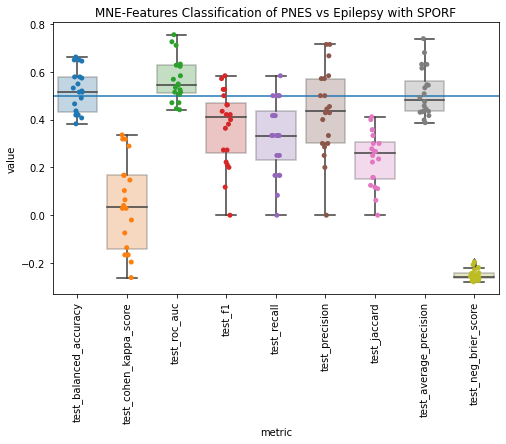

In [122]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x="metric", y="value", data=scores_df, ax=ax, boxprops=dict(alpha=0.3))
sns.stripplot(x="metric", y="value", data=scores_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axhline([0.5])
ax.set_title("MNE-Features Classification of PNES vs Epilepsy with SPORF")